In [13]:
import geopandas as gpd

final_data=gpd.read_file('D:/3A ENSAE/Machine Learning for climate risk/Project/Clean_Bases/final_data_20_24.gpkg')

final_data.head(3)

,SWI_UNIF_MENS,ym,swi_min,swi_mean,swi_max,prenei_sum,preliq_sum,pe_sum,evap_sum,t_avg,...,nom_officiel_en_majuscules,numero_du_canton,code_insee,codes_insee_des_arrondissements,code_insee_du_departement,code_insee_de_la_region,composition_du_canton,dept_name,region_name,geometry
0,0.949,2020-01,0.861,0.90229,0.956,0.0,48.2,29.5,18.7,7.225806,...,DUNKERQUE-2,17,5917,594,59,32,Fraction d'une commune et de commune(s) entièr...,Nord,Hauts-de-France,POINT (665362 7106108)
1,0.957,2020-01,0.858,0.90429,0.956,0.0,45.3,24.5,20.8,7.319355,...,MARCK,34,6234,626,62,32,Commune(s) entière(s),Pas-de-Calais,Hauts-de-France,POINT (625315 7098447)
2,0.957,2020-01,0.857,0.90400,0.956,0.0,45.3,24.8,20.5,7.319355,...,MARCK,34,6234,626,62,32,Commune(s) entière(s),Pas-de-Calais,Hauts-de-France,POINT (633311 7098380)


In [14]:
import pandas as pd
import numpy as np

# 1. Assigner le trimestre
def assign_quarter(ym):
    month = int(ym.split('-')[1])
    if month <= 3:
        return 'T1'
    elif month <= 6:
        return 'T2'
    elif month <= 9:
        return 'T3'
    else:
        return 'T4'

final_data['quarter'] = final_data['ym'].apply(assign_quarter)

# 2. Calculer le 25e percentile par commune et trimestre
percentiles_25 = final_data.groupby(['code_insee', 'quarter'])['SWI_UNIF_MENS'].quantile(0.25)
percentiles_25 = percentiles_25.reset_index().rename(columns={'SWI_UNIF_MENS': 'SWI_25th'})

# 3. Joindre ce percentile à la table principale
final_data = final_data.merge(percentiles_25, on=['code_insee', 'quarter'], how='left')

# 4. Créer la variable binaire "drought_25"
final_data['drought_25'] = (final_data['SWI_UNIF_MENS'] < final_data['SWI_25th']).astype(int)

# Vérification
final_data[['code_insee', 'ym', 'quarter', 'SWI_UNIF_MENS', 'SWI_25th', 'drought_25']].head(10)


,code_insee,ym,quarter,SWI_UNIF_MENS,SWI_25th,drought_25
0,5917,2020-01,T1,0.949,0.9005,0
1,6234,2020-01,T1,0.957,0.9075,0
2,6234,2020-01,T1,0.957,0.9075,0
3,5920,2020-01,T1,0.949,0.8890,0
4,5920,2020-01,T1,0.949,0.8890,0
5,5912,2020-01,T1,0.949,0.9010,0
6,5941,2020-01,T1,0.951,0.8940,0
7,6218,2020-01,T1,0.962,0.9190,0
8,6219,2020-01,T1,0.957,0.9485,0
9,6234,2020-01,T1,0.957,0.9075,0


In [24]:
# Filtrer sur 2024
df_2024 = final_data[final_data['ym'].str.startswith('2024')]

# Compter les occurrences de chaque classe
print(df_2024['drought_25'].value_counts())


drought_25
0    71767
1     2345
Name: count, dtype: int64


In [28]:
final_data['drought_25'].value_counts()

drought_25
0    277690
1     92870
Name: count, dtype: int64

In [31]:
import pandas as pd
import xgboost as xgb

from sklearn.metrics import classification_report, roc_auc_score

# ============================================================
# 1. Definition of target and predictors
# ============================================================

# Target variable: binary drought indicator based on 25% quantile
target = "drought_25"

# Predictors used to explain drought occurrence
predictors = [
    'swi_min','swi_mean','swi_max',
    'prenei_sum','preliq_sum','pe_sum',
    'evap_sum','t_avg','ff_avg','q_avg','hu_avg',
    'dli_avg','ssi_avg','etp_avg',
    'tinf_avg','tsup_avg',
    'resr_neige_avg','resr_neige6_avg',
    'hteurneige_avg','hteurneige6_avg','hteurneigex_avg',
    'snow_frac_avg',
    'drainc_sum','runc_sum','ecoulement_sum',
    'wg_racine_avg','wgi_racine_avg',
    'ALEA',          # soil-related categorical variable
    'quarter',         # seasonal effect
    'region_name'      # regional heterogeneity
]

# ============================================================
# 2. Temporal train / test split
#    Train: 2020–2023
#    Test : 2024
# ============================================================

train_data = final_data[final_data["ym"].str.startswith(("2020", "2021", "2022", "2023"))].copy()
test_data  = final_data[final_data["ym"].str.startswith("2024")].copy()
# Keep only predictors and target
train_data = train_data[predictors + [target]]
test_data  = test_data[predictors + [target]]

# ============================================================
# 3. Categorical encoding (no data leakage)
#    Train and test are encoded together to ensure
#    consistent dummy variables
# ============================================================

categorical_cols = [
    'quarter',
    'region_name',
    'ALEA'
]

# Concatenate train and test for consistent encoding
full_data = pd.concat([train_data, test_data], axis=0)

full_data_encoded = pd.get_dummies(
    full_data,
    columns=categorical_cols,
    drop_first=True
)

# Separate back train and test sets
X = full_data_encoded.drop(columns=[target])
y = full_data_encoded[target]

X_train = X.loc[train_data.index]
X_test  = X.loc[test_data.index]
y_train = y.loc[train_data.index]
y_test  = y.loc[test_data.index]

# ============================================================
# 4. Handle class imbalance
# ============================================================

pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos

# ============================================================
# 5. XGBoost model definition and training
# ============================================================

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# ============================================================
# 6. Predictions and evaluation on 2024
# ============================================================

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.99      0.94      0.96     71767
           1       0.25      0.62      0.35      2345

    accuracy                           0.93     74112
   macro avg       0.62      0.78      0.66     74112
weighted avg       0.96      0.93      0.94     74112

ROC AUC: 0.9362204947585206


       feature  mean_abs_shap
1     swi_mean       1.437428
28  quarter_T3       0.859449
0      swi_min       0.425632
29  quarter_T4       0.401729
27  quarter_T2       0.379251
6     evap_sum       0.327518
8       ff_avg       0.280069
22  drainc_sum       0.270972
9        q_avg       0.228576
2      swi_max       0.168750


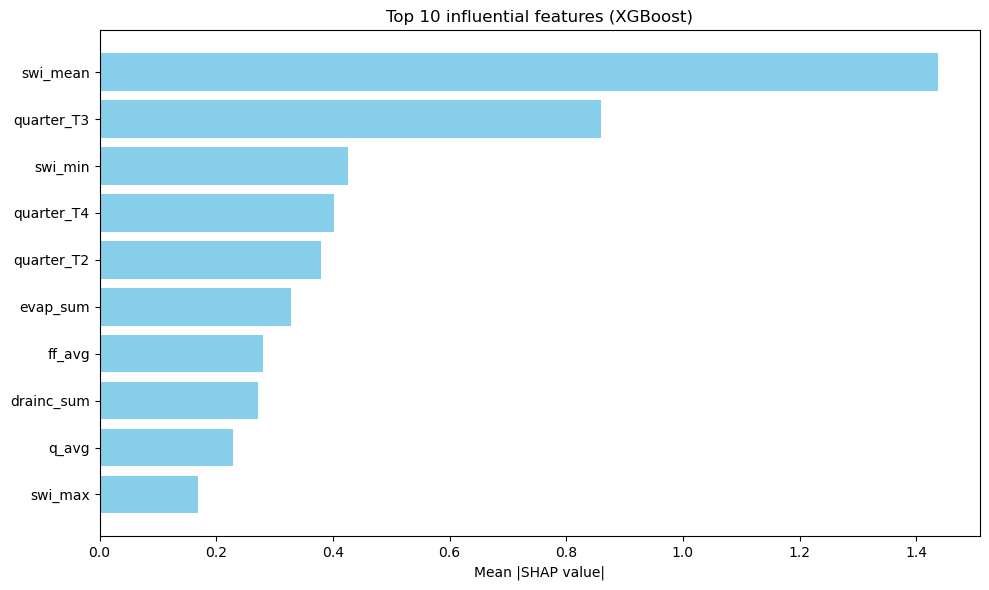

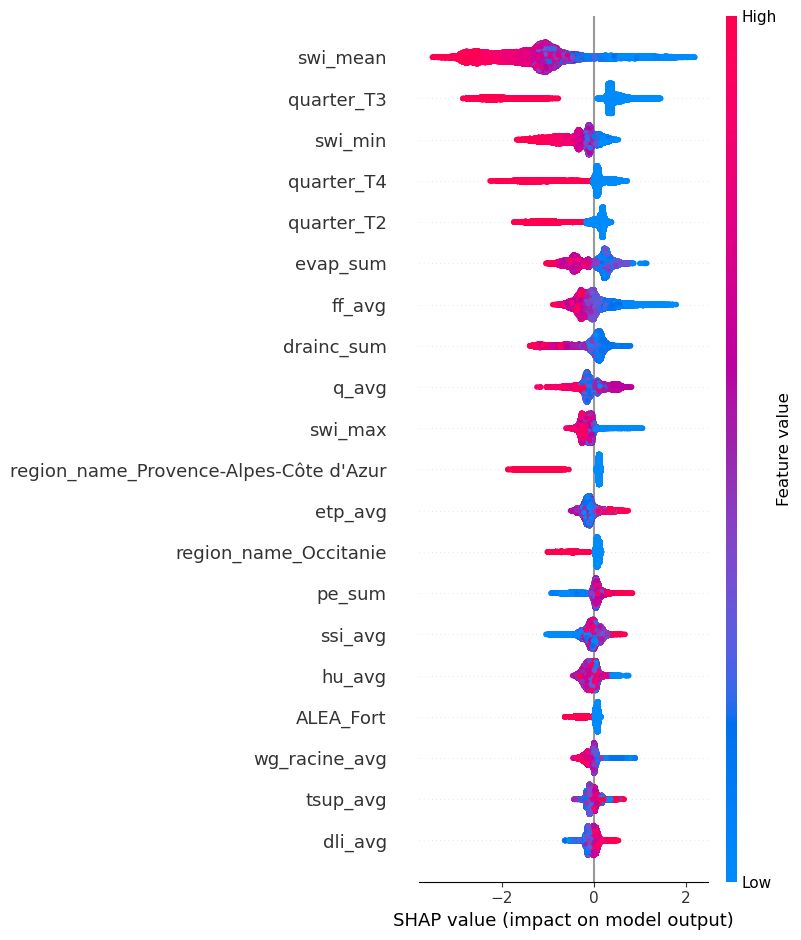

In [19]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -----------------------------
# 1. SHAP Explainer
# -----------------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)  # shape = (n_samples, n_features)

# -----------------------------
# 2. Moyenne absolue des SHAP par feature
# -----------------------------
shap_abs_mean = np.abs(shap_values).mean(axis=0)
shap_summary = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': shap_abs_mean
}).sort_values(by='mean_abs_shap', ascending=False)

# Afficher les 10 variables les plus influentes
print(shap_summary.head(10))

# -----------------------------
# 3. Plot des valeurs SHAP moyennes absolues
# -----------------------------
plt.figure(figsize=(10, 6))
plt.barh(
    shap_summary['feature'][:10][::-1],  # top 10, inversé pour barh
    shap_summary['mean_abs_shap'][:10][::-1],
    color='skyblue'
)
plt.xlabel("Mean |SHAP value|")
plt.title("Top 10 influential features (XGBoost)")
plt.tight_layout()
plt.show()

# -----------------------------
# 4. Optionnel : summary_plot interactif
# -----------------------------
shap.summary_plot(shap_values, X_test)


In [25]:
import pandas as pd
import numpy as np

# 1. Assigner le trimestre
def assign_quarter(ym):
    month = int(ym.split('-')[1])
    if month <= 3:
        return 'T1'
    elif month <= 6:
        return 'T2'
    elif month <= 9:
        return 'T3'
    else:
        return 'T4'

final_data['quarter'] = final_data['ym'].apply(assign_quarter)

# 2. Calculer le 5e percentile par commune et trimestre
percentiles_5 = final_data.groupby(['code_insee', 'quarter'])['SWI_UNIF_MENS'].quantile(0.05)
percentiles_5 = percentiles_5.reset_index().rename(columns={'SWI_UNIF_MENS': 'SWI_5th'})

# 3. Joindre ce percentile à la table principale
final_data = final_data.merge(percentiles_5, on=['code_insee', 'quarter'], how='left')

# 4. Créer la variable binaire "drought_5"
final_data['drought_5'] = (final_data['SWI_UNIF_MENS'] < final_data['SWI_5th']).astype(int)

# Vérification
final_data[['code_insee', 'ym', 'quarter', 'SWI_UNIF_MENS', 'SWI_5th', 'drought_5']].head(10)


,code_insee,ym,quarter,SWI_UNIF_MENS,SWI_5th,drought_5
0,5917,2020-01,T1,0.949,0.82330,0
1,6234,2020-01,T1,0.957,0.80970,0
2,6234,2020-01,T1,0.957,0.80970,0
3,5920,2020-01,T1,0.949,0.79620,0
4,5920,2020-01,T1,0.949,0.79620,0
5,5912,2020-01,T1,0.949,0.82330,0
6,5941,2020-01,T1,0.951,0.79240,0
7,6218,2020-01,T1,0.962,0.85490,0
8,6219,2020-01,T1,0.957,0.86995,0
9,6234,2020-01,T1,0.957,0.80970,0


In [27]:
# Filtrer sur 2024
df_2024 = final_data[final_data['ym'].str.startswith('2024')]

# Compter les occurrences de chaque classe
print(df_2024['drought_5'].value_counts())


drought_5
0    73785
1      327
Name: count, dtype: int64


In [29]:
final_data['drought_5'].value_counts()

drought_5
0    350757
1     19803
Name: count, dtype: int64

In [36]:
import pandas as pd
import xgboost as xgb

from sklearn.metrics import classification_report, roc_auc_score

# ============================================================
# 1. Definition of target and predictors
# ============================================================

# Target variable: binary drought indicator based on 5% quantile
target = "drought_5"

# Predictors used to explain drought occurrence
predictors = [
    'swi_min','swi_mean','swi_max',
    'prenei_sum','preliq_sum','pe_sum',
    'evap_sum','t_avg','ff_avg','q_avg','hu_avg',
    'dli_avg','ssi_avg','etp_avg',
    'tinf_avg','tsup_avg',
    'resr_neige_avg','resr_neige6_avg',
    'hteurneige_avg','hteurneige6_avg','hteurneigex_avg',
    'snow_frac_avg',
    'drainc_sum','runc_sum','ecoulement_sum',
    'wg_racine_avg','wgi_racine_avg',
    'ALEA',          # soil-related categorical variable
    'quarter',         # seasonal effect
    'region_name'      # regional heterogeneity
]

# ============================================================
# 2. Temporal train / test split
#    Train: 2020–2023
#    Test : 2024
# ============================================================

train_data = final_data[final_data["ym"].str.startswith(("2020", "2021", "2022", "2023"))].copy()
test_data  = final_data[final_data["ym"].str.startswith("2024")].copy()
# Keep only predictors and target
train_data = train_data[predictors + [target]]
test_data  = test_data[predictors + [target]]

# ============================================================
# 3. Categorical encoding (no data leakage)
#    Train and test are encoded together to ensure
#    consistent dummy variables
# ============================================================

categorical_cols = [
    'quarter',
    'region_name',
    'ALEA'
]

# Concatenate train and test for consistent encoding
full_data = pd.concat([train_data, test_data], axis=0)

full_data_encoded = pd.get_dummies(
    full_data,
    columns=categorical_cols,
    drop_first=True
)

# Separate back train and test sets
X = full_data_encoded.drop(columns=[target])
y = full_data_encoded[target]

X_train = X.loc[train_data.index]
X_test  = X.loc[test_data.index]
y_train = y.loc[train_data.index]
y_test  = y.loc[test_data.index]

# ============================================================
# 4. Handle class imbalance
# ============================================================

pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos

# ============================================================
# 5. XGBoost model definition and training
# ============================================================

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    #scale_pos_weight=scale_pos_weight,
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# ============================================================
# 6. Predictions and evaluation on 2024
# ============================================================

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     73785
           1       0.17      0.02      0.03       327

    accuracy                           1.00     74112
   macro avg       0.58      0.51      0.52     74112
weighted avg       0.99      1.00      0.99     74112

ROC AUC: 0.9515580124831651
